# Procesos de difusión
$$ dX_t = \mu(X_t) dt + \sigma(X_t)dW_t $$

## Modelo de Jacobi
$$ dX_t = \theta (\mu - X_t) dt + \sigma \sqrt{X_t(1-X_t)} d W_t \qquad X_0 \geq 0, \qquad \theta, \mu, \sigma > 0 $$

Se tomará la reparametrización $\alpha_1 = \theta \mu, \alpha_2 = \theta$. Por lo que el modelo se convierte en
$$ dX_t = (\alpha_1 - \alpha_2X_t) dt + \sigma \sqrt{X_t(1-X_t)} d W_t \qquad X_0 \geq 0, \qquad a_1, a_2, \sigma > 0 $$

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from matplotlib import gridspec
from scipy.stats import linregress, truncnorm, multivariate_normal, norm
from statsmodels.stats.diagnostic import lilliefors
from datetime import datetime

Los datos empleados fueron perturbados mediante ruido estocástico previo al análisis y eliminados del código para garantizar la protección de la información sensible de la organización

# Simulación por Milstein
$$ X_{n+1} = X_n + \mu(X_n)\Delta t + \sigma (X_n) \Delta W_n + \frac{1}{2}\sigma (X_n) \sigma ' (X_n)[(\Delta W_n)^2 - \Delta t] $$

## Para el modelo de Jacobi tenemos que
$$ X_{n+1} = X_n + (\alpha_1 - \alpha_2 X_n) \Delta t + \sigma \sqrt{X_n (1-X_n)} \Delta W_n + \frac{1}{4}\sigma^2(1-2X_n) [(\Delta W_n)^2 - \Delta t] $$

In [4]:
# Parametros a variar
num_iter = 1000
a1 = 4.5
a2 = 15
sigma = 0.2

sigma_inicial = 1000
burn_in_frac = 0.2

T = 1
porcentaje = 0.1

semilla = 2025

# Modelo a elegir
indicador = ACM0016_MX
if np.array_equal(indicador,ACM0001c):
    alertamiento_amarillo = 0.50001
    alertamiento_rojo = 0.70001
elif np.array_equal(indicador,ACM0001b):
    alertamiento_amarillo = 0.5
    alertamiento_rojo = 0.7
else:
    alertamiento_amarillo = 0.8
    alertamiento_rojo = 0.9

confianza = 0.90
meses_predecir = 6
num_estimaciones_prediccion = 500

In [5]:
# Otros parametros
x0 = 0.9
N = T*1000
Dt = T/N

In [6]:
# Trayectoria modelo de Jacobi
def simul_Jacobi(N, x0, Dt, a1, a2, sigma):

  x = np.zeros(N+1)
  x[0] = x0
  z = np.random.normal(0,1,N)

  for i in range(N):
    drift = (a1 - a2*x[i])*Dt
    dW = np.sqrt(Dt)*z[i]
    diff = sigma*np.sqrt(x[i]*(1-x[i]))*dW
    corr = 0.25*sigma**2*(1 - 2*x[i])*((dW**2) - Dt)
    x[i+1] = x[i] + drift + diff + corr
    x[i+1] = max(0, min(1, x[i+1]))

  return x

# Obtener trayectoria
np.random.seed(semilla)
X = simul_Jacobi(N, x0, Dt, a1, a2, sigma)
t = np.linspace(0,T,len(X))

# Estimacion de parametros
def Estimador(X, T):
  X = np.asarray(X, float)
  n = len(X) - 1
  dt = T / n

  Xlag = X[:-1]
  dX   = np.diff(X)
  y = dX / dt

  slope, intercept, *_ = linregress(Xlag, y)
  alpha2_hat = -slope
  alpha1_hat = intercept

  num = np.sum(dX**2)
  den = np.sum(Xlag * (1 - Xlag) * dt)
  sigma_hat = np.sqrt(num / den)

  return {"alpha1_hat": alpha1_hat,
          "alpha2_hat": alpha2_hat,
          "sigma_hat":  sigma_hat}

n = len(X)
k = int(np.floor(n * porcentaje))

# Reducimos la trayectoria
indices = np.round(np.linspace(1, n, num=k)).astype(int) - 1 # -1 ya que python inicia en 0
X_reducido = X[indices]
t_reducido = np.linspace(0, T, len(X_reducido))

# Puentes de difusión
def Bridge_MM(n, x0, xT, dt, a1, a2, sigma):
    bridge = np.zeros(n+1)

    ban = 0 # indica cuando hay cruce
    while ban == 0:

        X1 = simul_Jacobi(n, x0, dt, a1, a2, sigma)
        X2 = simul_Jacobi(n, xT, dt, a1, a2, sigma)
        Y = X2[::-1]

        if X1[0] <= Y[0]:
          for i in range(1,n+1):
            if X1[i] > Y[i]:
              bridge[:i] = X1[:i]
              bridge[i:] = Y[i:]
              ban = 1
              break

        else:
          for i in range(1,n+1):
            if X1[i] < Y[i]:
              ban = 1
              bridge[:i] = X1[:i]
              bridge[i:] = Y[i:]

              break

    return(bridge)

# Funcion para reconstruir el puente
def comp_Brige(X, nbri, delta_d, a1, a2, sigma):
  X_reconstruido = []
  for i in range(len(X)-1):
    puente = Bridge_MM(nbri, X[i], X[i+1], delta_d, a1, a2, sigma)
    X_reconstruido.extend(puente)

  return(np.array(X_reconstruido))

nbri = int(1/porcentaje)
delta_d = T / ((len(X_reducido) - 1) * nbri)

# Construir el puente
nbri = int(1/porcentaje)
X_reconstruido = comp_Brige(X_reducido, nbri, delta_d, a1, a2, sigma)
t_reconstruido = np.linspace(0, T, len(X_reconstruido))

# Estimadores
Estimadores = pd.DataFrame({"Parametros":["a1", "a2", "sigma"],
                            "Reales":[a1, a2, sigma],
                            "Completa":[Estimador(X,T)['alpha1_hat'],
                                        Estimador(X,T)['alpha2_hat'],
                                        Estimador(X,T)['sigma_hat']],
                            "Reducida":[Estimador(X_reducido,T)['alpha1_hat'],
                                        Estimador(X_reducido,T)['alpha2_hat'],
                                        Estimador(X_reducido,T)['sigma_hat']],
                            "Reconstruida":[Estimador(X_reconstruido,T)['alpha1_hat'],
                                            Estimador(X_reconstruido,T)['alpha2_hat'],
                                            Estimador(X_reconstruido,T)['sigma_hat']]})

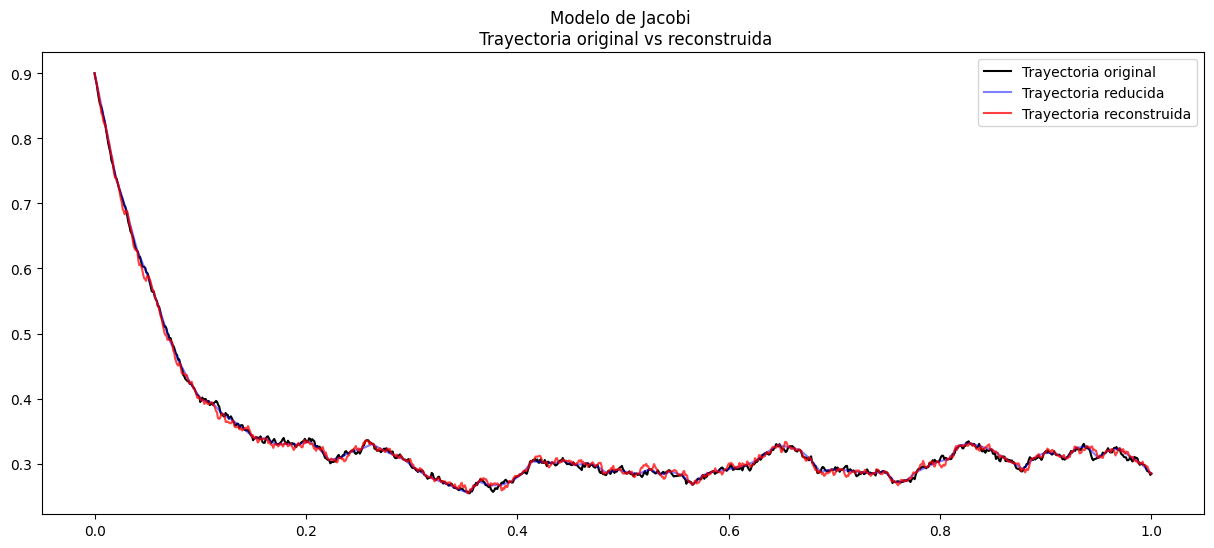

,Parametros,Reales,Completa,Reducida,Reconstruida
0,a1,4.5,4.479960,4.165158,4.587631
1,a2,15.0,15.221981,14.138781,15.539451
2,sigma,0.2,0.225064,0.415448,0.235087


In [7]:
# Grafico de trayectorias
plt.figure(figsize=(15, 6))
plt.plot(t, X, color="black", alpha=1, label="Trayectoria original")
plt.plot(t_reducido, X_reducido, color="blue", alpha=0.5, label="Trayectoria reducida")
plt.plot(t_reconstruido, X_reconstruido, color="red", alpha=0.75, label="Trayectoria reconstruida")
plt.title("Modelo de Jacobi \n Trayectoria original vs reconstruida")
plt.legend()
plt.show()

Estimadores

# Algoritmo Jacobi Gibbs Sample
Consideramos $\alpha = (\theta,\mu)$
1. Generar $\alpha \sim N_{T(0)} (\alpha_0, \Sigma_0) $ (Normal truncada en 0) y $\beta \sim exp\{\beta_0\} $.\
Hacer $k=1$ y $\theta^k = (\alpha^k, \beta^k)$, con $\alpha^k=\alpha$ y $\beta^k = \beta$
2. Generar $Z_t^i$ con $i=1,...,n$. Dados $X^d$ (Observaciones) y $\theta^k$
3. $\alpha^{k+1} \sim N_{T(0)}([\nu_{\beta} + \alpha_0\Sigma_0^{-1}][\Lambda_{\beta} + \Sigma_0^{-1}]^{-1}, [\Lambda_{\beta} + \Sigma^{-1}_0]^{-1}) $\
$ \beta^{k+1} \sim \pi_0(\theta_{\beta}) \mathcal{L}(\theta^k; Y_{obs}, Y_{mis}) $
4. Regresamos al paso 2

In [8]:
## Funciones

# Funcion h
def h(x, sigma):
  return((1/sigma)*(np.arcsin(2*x-1))) # quite pi/2

# Funcion h^{-1}
def h_1(y,sigma):
  #return((1/2)*(np.sin(sigma*y - np.pi/2)+1))
  return((1/2)*(np.sin(sigma*y)+1)) # quite pi/2

# Funcion b_\alpha
def b_alpha(a1, a2, x):
  return(a1 - a2*x)

# Funcion sigma_beta
def sigma_beta(sigma, x):
  return(sigma*np.sqrt(x*(1-x)))

# Funcion derivada de sigma_beta
def sigma_beta_der(sigma, x):
  derivada = (1-2*x)/(2*np.sqrt(x*(1-x)))
  return(derivada*sigma)

# Funcion mu_alpha_beta
def mu_alpha_beta(x, a1, a2, sigma):
  numerador = b_alpha(a1, a2, h_1(x, sigma))
  denonminador = sigma_beta(sigma, h_1(x, sigma))
  derivada = sigma_beta_der(sigma, h_1(x, sigma))
  return((numerador/denonminador) - (1/2)*derivada)

def simul_Jacobi_Lamp(N, x0, Dt, a1, a2, sigma):
  x = np.zeros(N+1)
  x[0] = x0
  z = np.random.normal(0,1,N)
  for i in range(N):
    dW = np.sqrt(Dt)*z[i]
    x[i+1] = x[i] + mu_alpha_beta(x[i], a1, a2, sigma)*Dt + dW
  return x

# Puentes de difusión con transformacion de Lamperti
def Bridge_MM_Lamp(n, x0, xT, dt, a1, a2, sigma):
    bridge = np.zeros(n+1)

    ban = 0 # indica cuando hay cruce
    while ban == 0:

        X1 = simul_Jacobi_Lamp(n, x0, dt, a1, a2, sigma)
        X2 = simul_Jacobi_Lamp(n, xT, dt, a1, a2, sigma)
        Y = X2[::-1]

        if X1[0] <= Y[0]:
          for i in range(1,n+1):
            if X1[i] > Y[i]:
              bridge[:i] = X1[:i]
              bridge[i:] = Y[i:]
              ban = 1
              break

        else:
          for i in range(1,n+1):
            if X1[i] < Y[i]:
              ban = 1
              bridge[:i] = X1[:i]
              bridge[i:] = Y[i:]

              break

    return(bridge)

# Funcion para reconstruir el puente
def comp_Bridge_Lamp(X, nbri, delta_d, a1, a2, sigma):
  X_reconstruido = []
  for i in range(len(X)-1):
    puente = Bridge_MM_Lamp(nbri, X[i], X[i+1], delta_d, a1, a2, sigma)
    X_reconstruido.extend(puente[:-1])

  X_reconstruido.append(X[-1])
  return(np.array(X_reconstruido))

# Distribucion a priori de alpha (normal truncada)
def alpha_prior(alpha_0):
  mu, sigma = alpha_0[0], alpha_0[1]
  a, b = 0, np.inf                                            #Limites de la normal truncada
  a_std, b_std = (a - mu) / sigma, (b - mu) / sigma           #Estandarizar límites

  alpha = truncnorm(a_std, b_std, loc=mu, scale=sigma).rvs(1) #.rvs genera valores aleatorios

  return(alpha)

# Distribucion a priori de beta (exponencial)
def beta_prior(beta_0):
  sigma = np.random.exponential(scale=1/beta_0, size=1)
  return(sigma)

# Calculo de las C's para l_t^i(b,b0)
def Cal_Cs(X_d, del_d, delta, beta0):
    seqd = np.arange(0, del_d + delta, delta)
    seqr = np.flip(seqd)
    n = len(X_d) - 1
    nbri = del_d/delta_d
    nc = int((n*nbri) + 1)
    Cs = np.zeros((2, nc))

    for i in range(1, n + 1):
      ini = int((i - 1) * nbri)
      fin = int(i * nbri + 1)
      Cs[0, ini:fin] = -(seqr * X_d[i - 1]) / (beta0 * del_d) - (seqd * X_d[i]) / (beta0 * del_d)
      Cs[1, ini:fin] =  (seqr * X_d[i - 1]) / (del_d)         + (seqd * X_d[i]) / (del_d)

    return(Cs)

# Calculo de la integral de una trayectoria
def int_path(path, delta):
  n = len(path) - 1
  integ = np.zeros(n)
  for i in range(0,n):
    integ[i] = (path[i] + path[i+1])*delta / 2
  int_acu = np.sum(integ)

  return(int_acu)

# Funcion para obtener una normal truncada en 0
def truncnorm_bivariada(mu, cov, size):
    muestras = []
    while len(muestras) < size:
        x = multivariate_normal.rvs(mean=mu, cov=cov)
        u = np.random.uniform(size=1)
        if np.all(x >= 0) :  # truncada en 0
            muestras.append(x)
    return np.array(muestras)

In [9]:
# Constuiremos los puentes Zs
np.random.seed(semilla)
X_d = X_reducido

# Distribuciones prior
Sigma_0 = np.array([[sigma_inicial,0],[0,sigma_inicial]])
Sigma_0_inv = np.linalg.inv(Sigma_0)

# beta prior (usaremos la real)
b0 = beta_prior(4)
b0 = sigma

# Valores de alpha prior
a1_inicial = Estimador(X_d,T)['alpha1_hat']
a2_inicial = Estimador(X_d,T)['alpha2_hat']

a0 = truncnorm_bivariada([a1_inicial, a2_inicial], Sigma_0,1)
a0_1 = a0[0][0]
a0_2 = a0[0][1]

# Transformacion de Lamperti
Ys = (1/b0)*(np.arcsin(2*X_d - 1))
t_Ys = np.linspace(0, T, len(Ys))

valores_a1 = [a0_1]
valores_a2 = [a0_2]

for i in range(num_iter):
    # Construir puentes
    Zs = comp_Bridge_Lamp(Ys, nbri, delta_d, a0_1, a0_2, b0)
    t_d = np.linspace(0, T, len(Zs))

    # Obtener l_t^i(b,b0)
    delta = T/len(X_d)
    del_d = T/len(Zs)
    #beta = sigma
    #Cs = Cal_Cs(X_d, del_d, delta, b0)
    #l = Cs[0] + (1/beta)*Cs[1]
    l = 0 # Por el momento, l sera cero

    # Calculo de las eta_i's
    eta = (1/2)*(np.sin(b0*(Zs+l))+1)
    eta_d = (b0/2)*np.cos(b0*(Zs+l))
    
    # Calculo de las D's
    D1 = np.log(np.abs((X_d[-1]*(X_d[0]-1))/(X_d[0]*(X_d[-1]-1))))
    D2 = np.log(np.abs((1-X_d[-1])/(1-X_d[0])))

    # Calculo de la primera entrada del vector de Nu
    camino = (eta_d*(1-2*eta)) / (eta*(1-eta))
    integral = int_path(camino, delta_d)
    nu_1 = (1/b0**2)*D1 + (1/2)*integral

    # Calculo de la segunda entrada del vector Nu
    camino2 = (eta_d*(1-2*eta))/(1-eta)
    integral2 = int_path(camino2, delta_d)
    nu_2 = (1/b0**2)*D2 + (1/2)*(t_d[-1]-t_d[0]) - (1/2)*integral2

    # Calculo de la entrada 1,1 de la matriz Lambda
    camino3 = 1/(eta*(1-eta))
    integral3 = int_path(camino3, delta_d)
    Lambda_11 = integral3

    # Calculo de la entrada 2,2 de la matriz Lambda
    camino4 = eta/(1-eta)
    integral4 = int_path(camino4, delta_d)
    Lambda_22 = integral4

    # Calculo de la entrada 1,2 y 2,1 de la matriz Lambda
    camino5 = 1/(1-eta)
    integral5 = int_path(camino5, delta_d)
    Lambda_12 = -integral5

    # Vector Nu y Matriz Lambda
    nu = np.array([nu_1, nu_2])
    Lambda = (1/b0**2)*np.array([[Lambda_11,Lambda_12],[Lambda_12,Lambda_22]])

    # Normal truncada para generar el lambda k+1

    # Media para la estimación de theta
    media = np.dot(nu + np.dot(a0, Sigma_0_inv), np.linalg.inv(Lambda + Sigma_0_inv))[0]
    varianza = np.linalg.inv(Lambda + Sigma_0_inv)

    a0_1 = truncnorm_bivariada(media, varianza, 1)[0][0]
    a0_2 = truncnorm_bivariada(media, varianza, 1)[0][1]

    valores_a1.append(a0_1)
    valores_a2.append(a0_2)

    print(f'{i+1}/{num_iter}', end='\r')

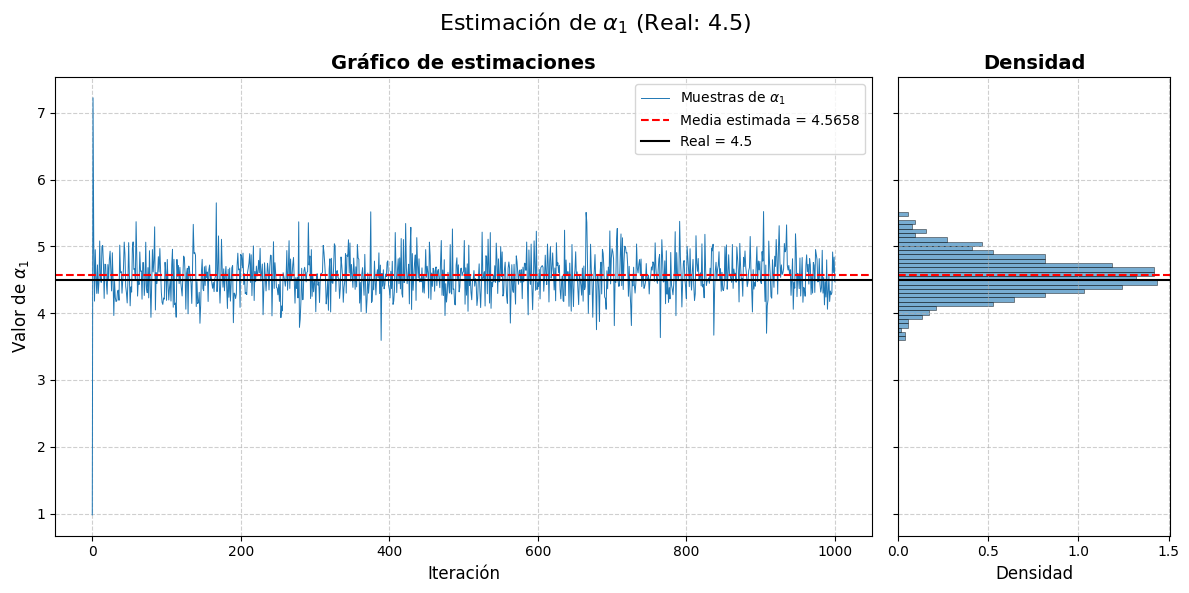

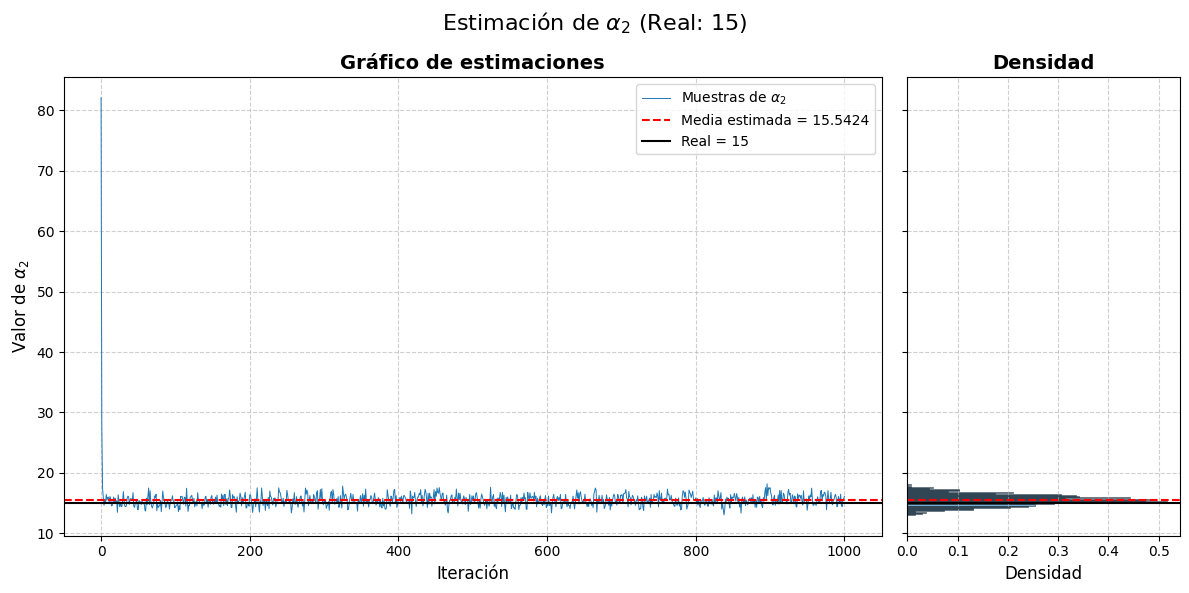

In [10]:
def plot_trace_hist(valores, valor_real, nombre_parametro, burn_in_frac=0.5):

    # 1. Procesar datos
    iteraciones = np.arange(len(valores))
    inicio = int(len(iteraciones) * burn_in_frac)
    val_convergentes = valores[inicio:]
    media_post = np.mean(val_convergentes)

    color = '#1f77b4'

    # 2. Crear figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True, 
                                   gridspec_kw={'width_ratios': [3, 1]})
    
    # Estimaciones
    ax1.plot(iteraciones, valores, linewidth=0.7, color=color, label=f'Muestras de ${nombre_parametro}$')
    ax1.axhline(y=media_post, color='red', linestyle='--', linewidth=1.5, label=f'Media estimada = {media_post:.4f}')
    ax1.axhline(y=valor_real, color='black', linestyle='-', linewidth=1.5, label=f'Real = {valor_real}')
    
    ax1.set_title("Gráfico de estimaciones", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Iteración", fontsize=12)
    ax1.set_ylabel(f"Valor de ${nombre_parametro}$", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(fontsize=10)
    
    # Histograma
    ax2.hist(val_convergentes, bins=30, density=True, orientation='horizontal',
             color=color, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax2.axhline(y=media_post, color='red', linestyle='--', linewidth=1.5)
    ax2.axhline(y=valor_real, color='black', linestyle='-', linewidth=1.5)
    
    ax2.set_title("Densidad", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Densidad", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.suptitle(f"Estimación de ${nombre_parametro}$ (Real: {valor_real})", fontsize=16)
    plt.tight_layout()
    plt.show()

# Obtener graficos
plot_trace_hist(valores_a1, a1, "\\alpha_1", burn_in_frac)
plot_trace_hist(valores_a2, a2, "\\alpha_2", burn_in_frac)

In [11]:
media_alpha_1 = np.mean(valores_a1[int(len(valores_a1)*burn_in_frac):])
media_alpha_2 = np.mean(valores_a2[int(len(valores_a2)*burn_in_frac):])

# Intervalo de confianza alpha_1
a = 100*(1-confianza)/2
inf_a1 = np.percentile(valores_a1[int(len(valores_a1)*burn_in_frac):], a)
sup_a1 = np.percentile(valores_a1[int(len(valores_a1)*burn_in_frac):], 100-a)
int_conf_a1 = f'[{inf_a1:.4f}, {sup_a1:.4f}]'

# Intervalo de confianza alpha_2
a = 100*(1-confianza)/2
inf_a2 = np.percentile(valores_a2[int(len(valores_a1)*burn_in_frac):], a)
sup_a2 = np.percentile(valores_a2[int(len(valores_a1)*burn_in_frac):], 100-a)
int_conf_a2 = f'[{inf_a2:.4f}, {sup_a2:.4f}]'

Estimadores_final = pd.DataFrame({"Parametros":["a1", "a2", "sigma"],
                                  "Reales":[a1, a2, sigma],
                                  "Completa":[Estimador(X,T)['alpha1_hat'],
                                              Estimador(X,T)['alpha2_hat'],
                                              Estimador(X,T)['sigma_hat']],
                                    "Reducida":[Estimador(X_reducido,T)['alpha1_hat'],
                                                Estimador(X_reducido,T)['alpha2_hat'],
                                                Estimador(X_reducido,T)['sigma_hat']],
                                    "Reconstruida":[Estimador(X_reconstruido,T)['alpha1_hat'],
                                                    Estimador(X_reconstruido,T)['alpha2_hat'],
                                                    Estimador(X_reconstruido,T)['sigma_hat']],
                                    'Gibbs Sample':[media_alpha_1, media_alpha_2, sigma],
                                    'Intervalo de confianza inf': [inf_a1, inf_a2, "na"],
                                    'Intervalo de confianza sup': [sup_a1, sup_a2, "na"]
                                    })

Estimadores_final

,Parametros,Reales,Completa,Reducida,Reconstruida,Gibbs Sample,Intervalo de confianza inf,Intervalo de confianza sup
0,a1,4.5,4.479960,4.165158,4.587631,4.565757,4.111996,5.0645
1,a2,15.0,15.221981,14.138781,15.539451,15.542387,14.09607,17.056751
2,sigma,0.2,0.225064,0.415448,0.235087,0.200000,na,na


# Aplicación a KRIs
ACM0001c \
ACM0001b \
ACM0016_MX

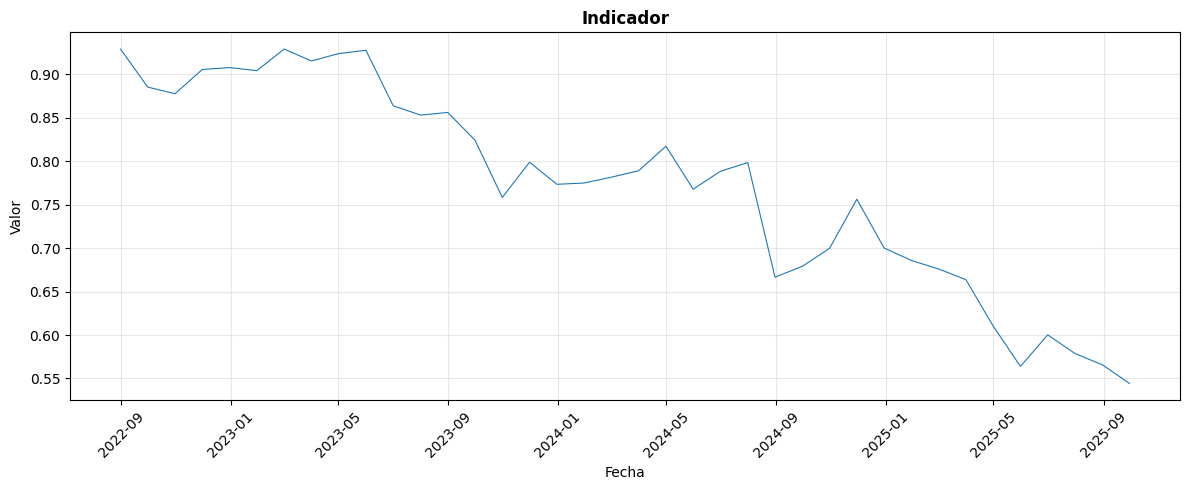

In [12]:
fecha_inicio = "2022-08-31"
fecha_fin = "2025-09-30"

def graficar_series_separadas(datos_dict, fecha_inicio, fecha_fin):
    n = len(datos_dict)
    
    # Crear la figura con 'n' filas (una para cada gráfica)
    # sharex=True hace que todas compartan el mismo zoom en el eje de fechas
    fig, axes = plt.subplots(n, 1, figsize=(12, 5 * n), sharex=True)
    
    # Asegurar que 'axes' sea iterable incluso si solo hay 1 gráfica
    if n == 1: axes = [axes]
    
    # Colores para variar un poco (azul y naranja por defecto)
    colores = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
    
    # Iterar sobre cada serie y su eje correspondiente
    for i, (ax, (nombre, datos)) in enumerate(zip(axes, datos_dict.items())):
        # Generar fechas
        fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, periods=len(datos))
        
        # Graficar
        color = colores[i % len(colores)] # Ciclar colores
        ax.plot(fechas, datos, linewidth=0.8, color=color)
        
        # Configuración del subplot
        ax.set_title(nombre, fontsize=12, fontweight='bold')
        ax.set_ylabel("Valor")
        ax.grid(True, alpha=0.3)
        
        # Configuración inteligente del eje X
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Ajustes finales
    plt.xlabel("Fecha")
    plt.xticks(rotation=45)
    plt.tight_layout() # Ajusta los espacios automáticamente
    plt.show()

mis_datos = {
    #"Indicador ACM0001c": ACM0001c,
    #"Indicador ACM0001b": ACM0001b,
    #"Indicador ACM0016_MX": ACM0016_MX,
    "Indicador": indicador
}

# 2. Llamas a la función una sola vez
graficar_series_separadas(mis_datos, "2022-08-31", "2025-09-30")

In [13]:
# Definir el formato de fechas (Año-Mes-Día)
formato = "%Y-%m-%d"

# Convertir texto a objetos datetime
d1 = datetime.strptime(fecha_inicio, formato)
d2 = datetime.strptime(fecha_fin, formato)

# Restar
diferencia = d2 - d1
T = diferencia.days
Estimador(indicador,T)

{'alpha1_hat': 0.0002008889925213163,
 'alpha2_hat': 0.0006972922427627352,
 'sigma_hat': 0.016921927372845844}

In [14]:
# Constuiremos los puentes Zs

np.random.seed(semilla)
porcentaje = len(indicador)/T
nbri = int(1/porcentaje)
X_d = indicador
delta_d = T / ((len(X_d) - 1) * nbri)

# Distribuciones prior
Sigma_0 = np.array([[sigma_inicial,0],[0,sigma_inicial]])
Sigma_0_inv = np.linalg.inv(Sigma_0)

# beta prior (usaremos la estimada)
b0 = beta_prior(4)
b0 = Estimador(indicador,T)['sigma_hat']

# Valores de alpha prior
a1_inicial = Estimador(X_d,T)['alpha1_hat']
a2_inicial = Estimador(X_d,T)['alpha2_hat']

a0 = truncnorm_bivariada([a1_inicial, a2_inicial], Sigma_0,1)
a0_1 = a0[0][0]
a0_2 = a0[0][1]

# Transformacion de Lamperti
Ys = (1/b0)*(np.arcsin(2*X_d - 1))
t_Ys = np.linspace(0, T, len(Ys))

valores_a1 = [a0_1]
valores_a2 = [a0_2]

for i in range(num_iter):
    # Construir puentes
    Zs = comp_Bridge_Lamp(Ys, nbri, delta_d, a0_1, a0_2, b0)
    t_d = np.linspace(0, T, len(Zs))

    # Obtener l_t^i(b,b0)
    delta = T/len(X_d)
    del_d = T/len(Zs)
    #beta = sigma
    #Cs = Cal_Cs(X_d, del_d, delta, b0)
    #l = Cs[0] + (1/beta)*Cs[1]
    l = 0 # Por el momento, l sera cero

    # Calculo de las eta_i's
    eta = (1/2)*(np.sin(b0*(Zs+l))+1)
    eta_d = (b0/2)*np.cos(b0*(Zs+l))
    
    # Calculo de las D's
    D1 = np.log(np.abs((X_d[-1]*(X_d[0]-1))/(X_d[0]*(X_d[-1]-1))))
    D2 = -np.log(np.abs((1-X_d[-1])/(1-X_d[0])))

    # Calculo de la primera entrada del vector de Nu
    camino = (eta_d*(1-2*eta)) / (eta*(1-eta))
    integral = int_path(camino, delta_d)
    nu_1 = (1/b0**2)*D1 + (1/2)*integral

    # Calculo de la segunda entrada del vector Nu
    camino2 = (eta_d*(1-2*eta))/(1-eta)
    integral2 = int_path(camino2, delta_d)
    nu_2 = -(1/b0**2)*D2 + (1/2)*(t_d[-1]-t_d[0]) - (1/2)*integral2

    # Calculo de la entrada 1,1 de la matriz Lambda
    camino3 = 1/(eta*(1-eta))
    integral3 = int_path(camino3, delta_d)
    Lambda_11 = integral3

    # Calculo de la entrada 2,2 de la matriz Lambda
    camino4 = eta/(1-eta)
    integral4 = int_path(camino4, delta_d)
    Lambda_22 = integral4

    # Calculo de la entrada 1,2 y 2,1 de la matriz Lambda
    camino5 = 1/(1-eta)
    integral5 = int_path(camino5, delta_d)
    Lambda_12 = -integral5

    # Vector Nu y Matriz Lambda
    nu = np.array([nu_1, nu_2])
    Lambda = (1/b0**2)*np.array([[Lambda_11,Lambda_12],[Lambda_12,Lambda_22]])

    # Normal truncada para generar el lambda k+1

    # Media para la estimación de theta
    media = np.dot(nu + np.dot(a0, Sigma_0_inv), np.linalg.inv(Lambda + Sigma_0_inv))[0]
    varianza = np.linalg.inv(Lambda + Sigma_0_inv)

    a0_1 = truncnorm_bivariada(media, varianza, 1)[0][0]
    a0_2 = truncnorm_bivariada(media, varianza, 1)[0][1]

    valores_a1.append(a0_1)
    valores_a2.append(a0_2)

    print(f'{i+1}/{num_iter}', end='\r')

In [15]:
def plot_trace_hist(valores, nombre_parametro, burn_in_frac=0.5):

    # 1. Procesar datos
    iteraciones = np.arange(len(valores))
    inicio = int(len(iteraciones) * burn_in_frac)
    val_convergentes = valores[inicio:]
    media_post = np.mean(val_convergentes)

    color = '#1f77b4'

    # 2. Crear figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True, 
                                   gridspec_kw={'width_ratios': [3, 1]})
    
    # Estimaciones
    ax1.plot(iteraciones, valores, linewidth=0.7, color=color, label=f'Muestras de ${nombre_parametro}$')
    ax1.axhline(y=media_post, color='red', linestyle='--', linewidth=1.5, label=f'Media estimada = {media_post:.4f}')
    
    ax1.set_title("Gráfico de estimaciones", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Iteración", fontsize=12)
    ax1.set_ylabel(f"Valor de ${nombre_parametro}$", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(fontsize=10)
    
    # Histograma
    ax2.hist(val_convergentes, bins=30, density=True, orientation='horizontal',
             color=color, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax2.axhline(y=media_post, color='red', linestyle='--', linewidth=1.5)
    
    ax2.set_title("Densidad", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Densidad", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.suptitle(f"Estimación de ${nombre_parametro}$", fontsize=16)
    plt.tight_layout()
    plt.show()

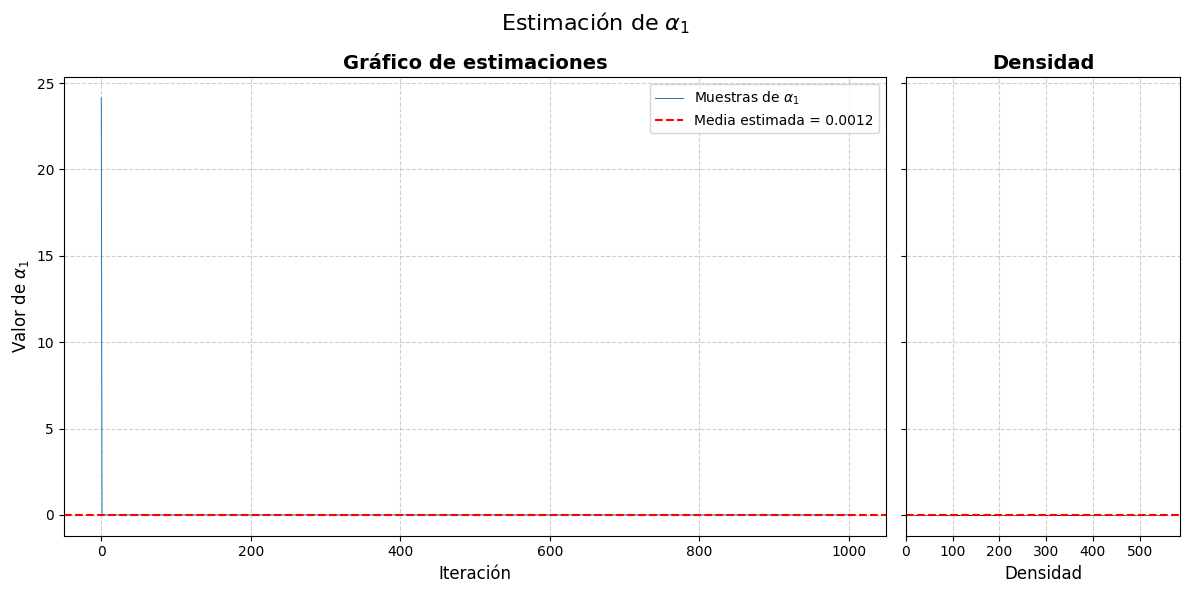

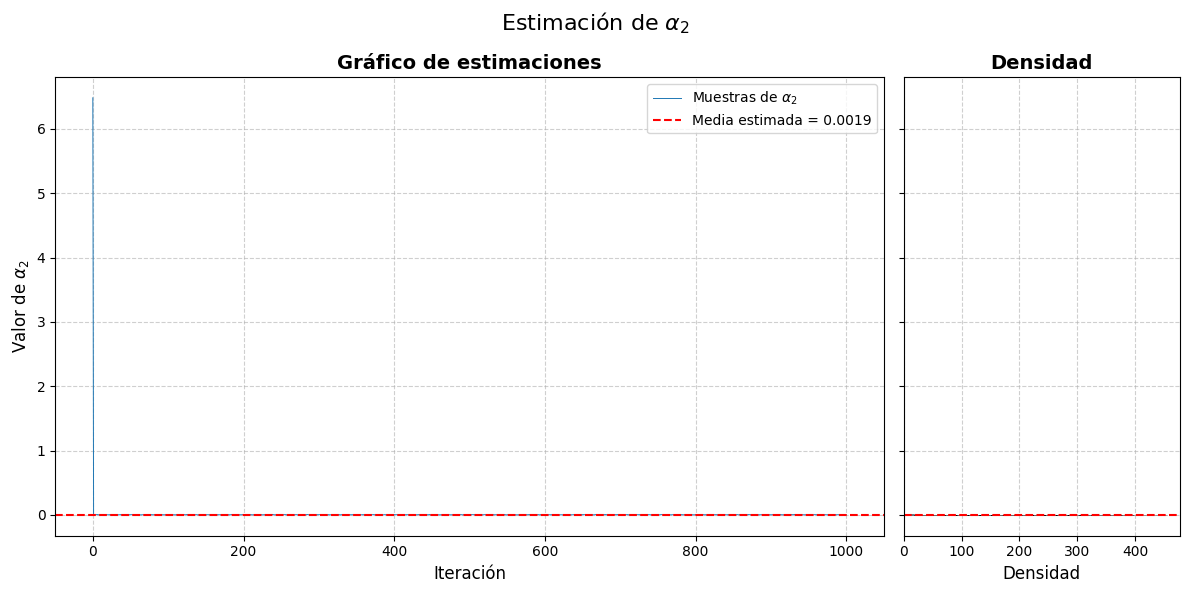

In [16]:
plot_trace_hist(valores_a1, "\\alpha_1", burn_in_frac)
plot_trace_hist(valores_a2, "\\alpha_2", burn_in_frac)

In [17]:
media_alpha_1 = np.mean(valores_a1[int(len(valores_a1)*burn_in_frac):])
media_alpha_2 = np.mean(valores_a2[int(len(valores_a2)*burn_in_frac):])

# Intervalo de confianza alpha_1
a = 100*(1-confianza)/2
inf_a1 = np.percentile(valores_a1[int(len(valores_a1)*burn_in_frac):], a)
sup_a1 = np.percentile(valores_a1[int(len(valores_a1)*burn_in_frac):], 100-a)

# Intervalo de confianza alpha_2
a = 100*(1-confianza)/2
inf_a2 = np.percentile(valores_a2[int(len(valores_a1)*burn_in_frac):], a)
sup_a2 = np.percentile(valores_a2[int(len(valores_a1)*burn_in_frac):], 100-a)

Estimadores_final = pd.DataFrame({'Gibbs Sample':[media_alpha_1, media_alpha_2, Estimador(indicador,T)['sigma_hat']],
                                  'Intervalo de confianza inf': [inf_a1, inf_a2, "na"],
                                  'Intervalo de confianza sup': [sup_a1, sup_a2, "na"]
                                    })

parametros = {0: 'alpha_1', 1: 'alpha_2', 2: 'sigma'}
Estimadores_final = Estimadores_final.rename(index=parametros)
Estimadores_final

,Gibbs Sample,Intervalo de confianza inf,Intervalo de confianza sup
alpha_1,0.001220,0.000096,0.002905
alpha_2,0.001877,0.000475,0.003965
sigma,0.016922,na,na


In [18]:
# Construir el puente
nbri = int(1/porcentaje)
delta_d = T / ((len(X_d) - 1) * nbri)
X_reconstruido = comp_Brige(X_d, nbri, delta_d, media_alpha_1, media_alpha_2, Estimador(indicador,T)['sigma_hat'])
t_reconstruido = np.linspace(0, T, len(X_reconstruido))

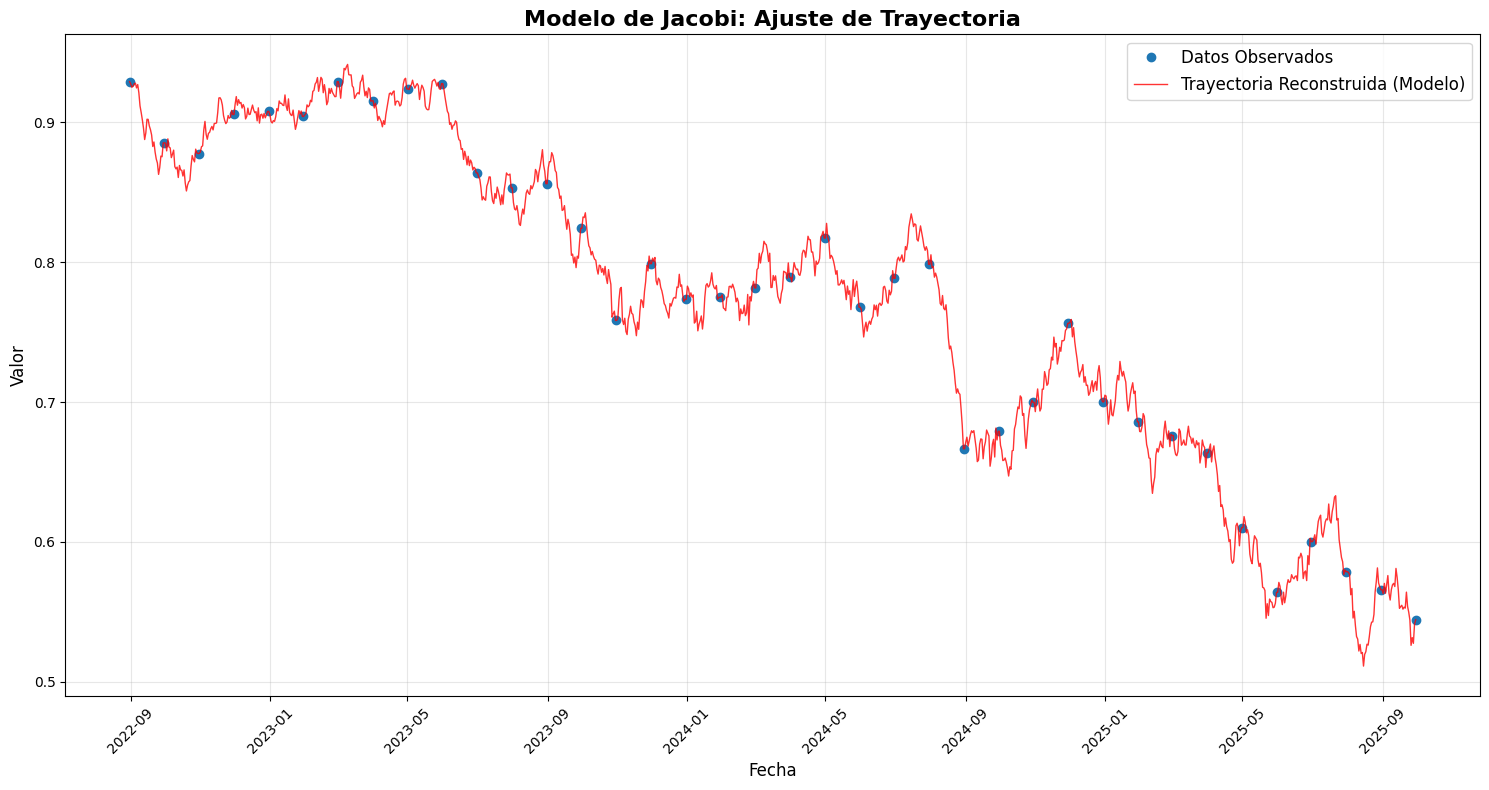

In [19]:
# Fechas para los puntos originales
fechas_originales = pd.date_range(start=fecha_inicio, end=fecha_fin, periods=len(indicador))

# Fechas para la trayectoria reconstruida
fechas_reconstruidas = pd.date_range(start=fecha_inicio, end=fecha_fin, periods=len(X_reconstruido))

# 3. Crear la gráfica única
fig, ax = plt.subplots(figsize=(15, 8))

# Graficar DATOS ORIGINALES (Puntos Azules)
ax.plot(fechas_originales, indicador, 'o', color='#1f77b4', label='Datos Observados')

# Graficar TRAYECTORIA RECONSTRUIDA (Línea Roja)
ax.plot(fechas_reconstruidas, X_reconstruido, color='red', label='Trayectoria Reconstruida (Modelo)', linewidth=1, alpha=0.8)

# 4. Formato y Estilo
ax.set_title("Modelo de Jacobi: Ajuste de Trayectoria", fontsize=16, fontweight='bold')
ax.set_xlabel("Fecha", fontsize=12)
ax.set_ylabel("Valor", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Formato inteligente de fechas en eje X
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Estimaciones de los parámetros originales
Como $\alpha_1=\theta\mu$ y $\alpha_2=\theta$\
Entonces $ \theta=\alpha_2$ y $\mu = \frac{\alpha_1}{\alpha_2} $

In [20]:
Estimadores_originales = Estimadores_final.T
Estimadores_originales['mu'] = Estimadores_originales['alpha_1'] / Estimadores_originales['alpha_2']
Estimadores_originales['theta'] = Estimadores_originales['alpha_2']
Estimadores_originales

,alpha_1,alpha_2,sigma,mu,theta
Gibbs Sample,0.00122,0.001877,0.016922,0.650007,0.001877
Intervalo de confianza inf,0.000096,0.000475,na,0.201829,0.000475
Intervalo de confianza sup,0.002905,0.003965,na,0.732573,0.003965


## Vida media del modelo
Si consideramos la parte determinista del modelo: $$ dX_t = \theta (\mu - X_t)dt $$
Esto es una ecuación diferencial de decaimiento exponencial. La solución para la distandcia entre el valor actual y la media es 
$$ E[X_t] - \mu = (X_0 - \mu) e^{-\theta t} $$

Esto significa que la distancia a la media $X_t-\mu$ se reduce exponencialmente con el tiempo.\
Para saber en qué tiempo esa distancia se reduce exactamente a la mitad, igualamos $$ e^{-\theta t} = \frac{1}{2} $$
De donde $$ t=\frac{ln(2)}{\theta} $$

In [21]:
# Estimadores
mu_est =  Estimadores_originales["mu"][0]
theta_est = Estimadores_originales["theta"][0]
sigma_est = Estimadores_originales["sigma"][0]

In [22]:
vida_media = np.log(2) / theta_est

# Probabilidad de alertamiento en la capacidad

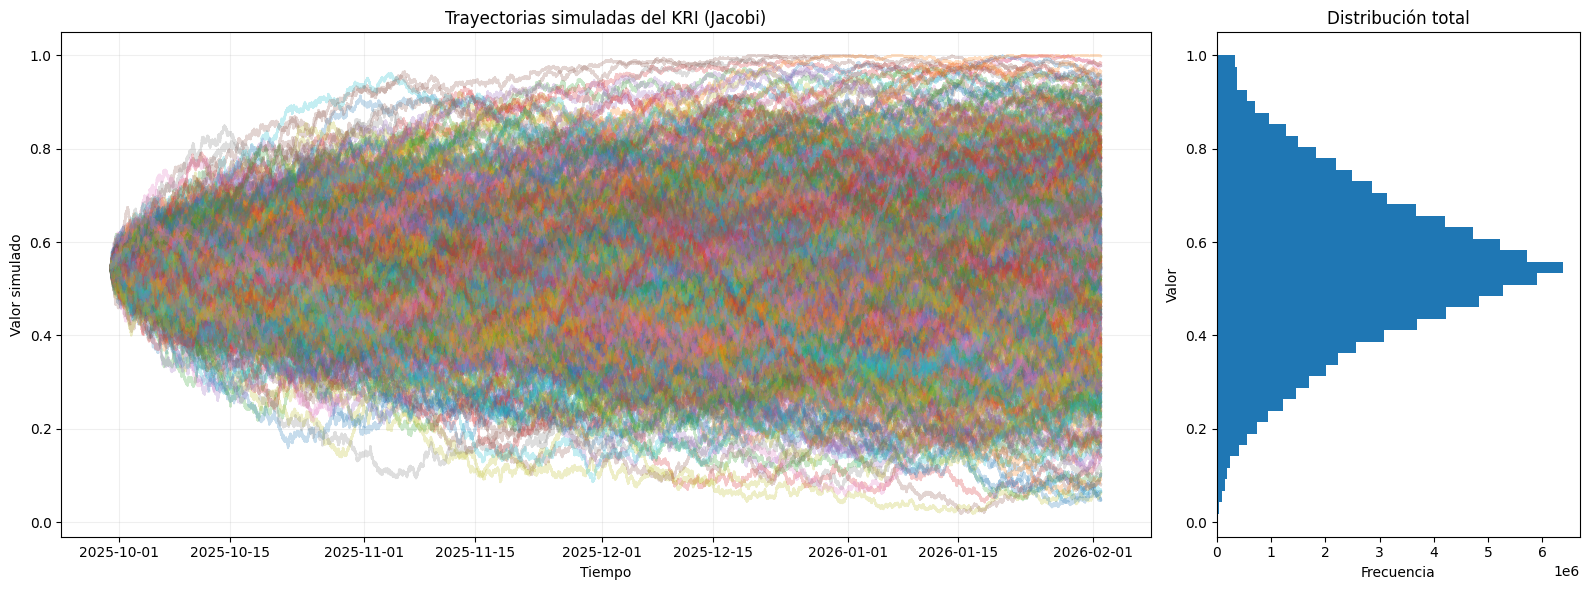

In [23]:
inicio = indicador[-1]
T = 30*meses_predecir
N = T*1000
Dt = T/N

# Crear fechas desde 2025-09-30 por 180 días
fechas = pd.date_range(start=fecha_fin, periods=N+1, freq="min")

iteraciones_estimacion = []

np.random.seed(semilla)

for i in range(num_estimaciones_prediccion):
    estimaciones = simul_Jacobi(N, inicio, Dt, media_alpha_1, media_alpha_2, Estimador(indicador,T)['sigma_hat'])
    iteraciones_estimacion.append(estimaciones)
    print(f'{i+1}/{num_estimaciones_prediccion} Construcción de trayectorias', end='\r')

iteraciones_estimacion = np.array(iteraciones_estimacion)
#t_estimaciones = np.linspace(0,T, len(estimaciones))

plt.figure(figsize=(16, 6))

gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # zona izquierda = trayectorias, derecha = histograma

# Trayectorias
ax1 = plt.subplot(gs[0])

for i in range(num_estimaciones_prediccion):
    ax1.plot(fechas, iteraciones_estimacion[i], alpha=0.25)
    print(f'{i+1}/{num_estimaciones_prediccion} Construcción de gráficas', end='\r')

ax1.set_title("Trayectorias simuladas del KRI (Jacobi)")
ax1.set_xlabel("Tiempo")
ax1.set_ylabel("Valor simulado")
ax1.grid(True, alpha=0.2)

# Histograma
ax2 = plt.subplot(gs[1])

# Aplanar todas las trayectorias en un solo vector
todos_los_puntos = iteraciones_estimacion.flatten()

ax2.hist(todos_los_puntos, bins=40, orientation="horizontal")
ax2.set_title("Distribución total")
ax2.set_xlabel("Frecuencia")
ax2.set_ylabel("Valor")

plt.tight_layout()
plt.show()

## Condiciones tipo Feller para Jacobi
Para que las fronteras sean "dificiles de alcanzar", se tiene que cumplir que $ 2 \theta \mu \geq \sigma^2 $ cerca de 0 y $ 2 \theta (1-\mu) \geq \sigma^2 $ cerca de 1

In [24]:
# Cerca de cero 
cerca_cero = 2*theta_est*mu_est >= sigma_est**2

# Cerca de 1
cerca_uno = 2*theta_est*(1-mu_est) >= sigma_est**2

In [25]:
2*theta_est*(1-mu_est)

0.001314001732492799

In [26]:
def simul_Jacobi(N, x0, Dt, a1, a2, sigma):

  x = np.zeros(N+1)
  x[0] = x0
  z = np.random.normal(0,1,N)

  for i in range(N):
    drift = (a1 - a2*x[i])*Dt
    dW = np.sqrt(Dt)*z[i]
    diff = sigma*np.sqrt(x[i]*(1-x[i]))*dW
    corr = 0.25*sigma**2*(1 - 2*x[i])*((dW**2) - Dt)
    x[i+1] = x[i] + drift + diff + corr
    x[i+1] = max(0, min(1, x[i+1]))

  return x

In [27]:
iteraciones_totales = iteraciones_estimacion.flatten()
media_iteraciones = np.mean(iteraciones_totales)
a = 100*(1-confianza)/2
inf_iteraciones = np.percentile(iteraciones_totales, a)
sup_iteraciones = np.percentile(iteraciones_totales, 100-a)

media_iteraciones, inf_iteraciones, sup_iteraciones

(0.5477207345084767, 0.26273244875130825, 0.8294081019201548)

In [28]:
excede_amarillo = iteraciones_totales[iteraciones_totales > alertamiento_amarillo]
prob_excesoamarillo = len(excede_amarillo) / len(iteraciones_totales)

excede_rojo = iteraciones_totales[iteraciones_totales > alertamiento_rojo]
prob_excesorojo = len(excede_rojo) / len(iteraciones_totales)

## Resumen de resultados

In [29]:
print(f"Resiliencia operativa: Reversión a la media, {theta_est}, con {vida_media} días de vida media después de un shock")
print(f'Evaluación de capacidad: {mu_est} en promedio')
print(f'Umbral de alerta en amarillo: {alertamiento_amarillo}')
print(f'Umbral de alerta en rojo: {alertamiento_rojo}')
print(f'Naturaleza del trafico: {sigma_est} de volatilidad')
print(f'Condiciones de tipo Feller cerca de cero: {cerca_cero}, cerca del uno: {cerca_uno}, si es true, no se acerca a los extremos 0,1')
print(f'Probabilidad de alertamiento en amarillo: {prob_excesoamarillo}')
print(f'Probabilidad de alertamiento en rojo: {prob_excesorojo}')

Resiliencia operativa: Reversión a la media, 0.0018771818224719884, con 369.248824094816 días de vida media después de un shock
Evaluación de capacidad: 0.6500068036130776 en promedio
Umbral de alerta en amarillo: 0.8
Umbral de alerta en rojo: 0.9
Naturaleza del trafico: 0.016921927372845844 de volatilidad
Condiciones de tipo Feller cerca de cero: True, cerca del uno: True, si es true, no se acerca a los extremos 0,1
Probabilidad de alertamiento en amarillo: 0.07017261015216582
Probabilidad de alertamiento en rojo: 0.018748251398603342


## Validación del modelo
Un proceso de difusión es de la forma $$ dX_t = \mu (X_t) dt + \sigma (X_t) dW_t $$
Aplicando transformación de Lamperti obtiene la forma $$ dY_t = \alpha (Y_t) dt + dW_t $$
En versión discreta se ve de la forma $$ Y_{t_i} - Y_{t_{i-1}} - \alpha (Y_{t_i}) = W_{t_i} - W_{t_{i-1}}, ~~~ W_{t_k} \sim N(0,1) $$
Si $$ Z_i = Y_{t_i} - Y_{t_{i-1}} - \alpha (Y_{t_i}) $$
Entonces $$ Z_1,...,Z_n \sim N(0,1) $$

In [81]:
# Obtencion de los valores de Z

yi = X_reconstruido[1:]
yi_1 = X_reconstruido[:-1]
alpha_Lamp = mu_alpha_beta(X_reconstruido, media_alpha_1, media_alpha_2, sigma_est)[1:]

z = yi - yi_1 - alpha_Lamp

In [82]:
# Prueba Kolmogorov Smirnov Lilliefors

stat, p = lilliefors(z)
print("Lilliefors:")
print("p-value =", p)

if p > 0.05:
    print("No se rechaza normalidad (p > 0.05)")
else:
    print("Se rechaza normalidad (p < 0.05)")

Lilliefors:
p-value = 0.10219520698463991
No se rechaza normalidad (p > 0.05)


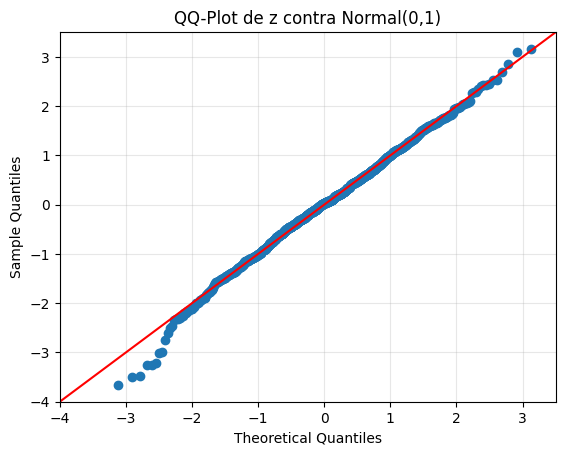

In [83]:
# QQ-Plot

sm.qqplot(z, line='45', fit=True)
plt.title("QQ-Plot de z contra Normal(0,1)")
plt.grid(alpha=0.3)
plt.show()

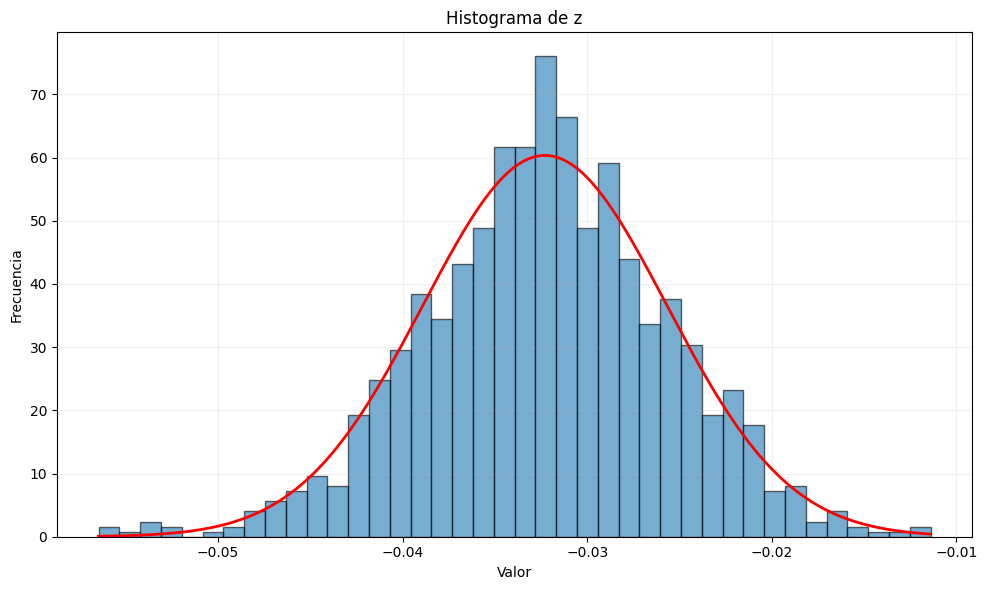

In [84]:
# Histograma vs Densidad

media_z = np.mean(z)
desv_est_z = np.std(z, ddof=1)
x_vals = np.linspace(min(z), max(z), 500)
pdf_vals = norm.pdf(x_vals, loc=media_z, scale=desv_est_z)

plt.figure(figsize=(10, 6))
plt.hist(z, bins=40, density=True, alpha=0.6, edgecolor='black')
plt.plot(x_vals, pdf_vals, 'r-', linewidth=2, label='Normal ajustada')
plt.title("Histograma de z")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()